In [2]:
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,f1_score,precision_score,recall_score

from sklearnex import patch_sklearn,unpatch_sklearn

from scipy.stats import f_oneway

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from Interaction_effect_features import get_data

from MetaHeuristicsFS import FeatureSelection

# from EvolutionaryFS import GeneticAlgorithmFS
# from SimmulatedAnnealingFS import SimulatedAnnealingFS
# from ACO import AntColonyOptimizationFS
# from PSOFinal import ParticleSwarmOptimizationFS

import shap

np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [3]:
def get_metrics(model,data_dict,problem_type,dependent_variable,features,cost_funct):
    '''
    problem_type = 'regression' or classification
    '''
    
    test_tree_cost = {}
    
    external_tree_cost = []
    external_tree_precision = []
    external_tree_recall = []
    
    data_external_test = data_dict['data_external_test']
    data_validation_test = data_dict['data_validation_test']
    
    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        fold_training = data_dict['fold_dict'][data_fold_index]['fold_training']
        fold_test = data_dict['fold_dict'][data_fold_index]['fold_test']
        
        #based on regression/classification
        if problem_type == 'regression':
            cost_function = cost_funct
        else:
            cost_function = f1_score
        
        Y_train = fold_training[dependent_variable]
        Y_test = fold_test[dependent_variable]
        Y_validation = data_validation_test[dependent_variable]
        Y_external = data_external_test[dependent_variable]
        
        model.fit(fold_training[features],Y_train)
                
        Y_test_tree = model.predict(fold_test[features])
        Y_validation_tree = model.predict(data_validation_test[features])
        Y_external_tree = model.predict(data_external_test[features])
        
        place_holder = np.mean([cost_funct(Y_test,Y_test_tree),cost_funct(Y_validation,Y_validation_tree)])
        
        #predict for test and calculate cost function
        test_tree_cost['CV Sample-'+str(data_fold_index)] = place_holder

        #predict for external test and calculate cost function
        external_tree_cost.append(cost_funct(Y_external,Y_external_tree))
        
        if problem_type != 'regression':
            external_tree_precision.append(precision_score(Y_external,Y_external_tree))
            external_tree_recall.append(recall_score(Y_external,Y_external_tree))
            
    #return cost
    if problem_type != 'regression':
        #print('External Test precision: ' + str(round(np.mean(external_tree_precision),2)) + ', recall: ' + str(round(np.mean(external_tree_recall),2)))
        print('External Test recall: ' + str(round(np.mean(external_tree_recall),2)))
    return test_tree_cost,external_tree_cost

In [4]:
def make_plot(metric,title,test_tree_cost,external_tree_cost):
    sns.set(rc={'figure.figsize':(16,8)})
    sns.set_context('paper', font_scale = 1.3)
    if metric=='RMSE':
        fig, ax = plt.subplots(1, 2)
    else:
        fig, ax = plt.subplots(1, 2, sharey=True)
        
    validation_name = [' External_Test','External_Test ',' External_Test ',' External_Test  ','  External_Test']

    ax[0].bar(list(test_tree_cost.keys()),list(test_tree_cost.values()))
    ax[0].set_title(metric + ' for test data and validation data')

    ax[1].bar(validation_name,external_tree_cost)
    ax[1].set_title(metric + ' for external test data')

    #plt.title('')
    
def get_data_for_FS(data_dict,dependent_variable,features_all):
    
    data_dict_for_SA = {}

#     x_validation = data_dict['data_external_test'][features_all]
#     y_validation = data_dict['data_external_test'][dependent_variable]
    
    x_validation = data_dict['data_validation_test'][features_all]
    y_validation = data_dict['data_validation_test'][dependent_variable]

    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        
        for feature in features_all:
            if feature not in data_dict['fold_dict'][data_fold_index]['fold_training'].columns:
                print(feature,'not present')

        data_dict_for_SA[data_fold_index]={'x_train':data_dict['fold_dict'][data_fold_index]['fold_training'][features_all],
                                           'y_train':data_dict['fold_dict'][data_fold_index]['fold_training'][dependent_variable],
                                           'x_test':data_dict['fold_dict'][data_fold_index]['fold_test'][features_all],
                                           'y_test':data_dict['fold_dict'][data_fold_index]['fold_test'][dependent_variable]}
    
#     for feature in features_all:
#         if '_Encoded' not in feature:
            
    
    return data_dict_for_SA,x_validation,y_validation,features_all

def last_preprocessing(data_dict):
    
    
    columns = ['ownercountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandownercountEncoded','fuelcountEncodedandownerMeanEncoded','ownercountEncodedandmaxpowerQuartileMeanEncoded','ownercountEncodedandkmdrivenQuartilecountEncoded','ownercountEncodedandmileageQuartileMeanEncoded','ownercountEncodedandmileageQuartilecountEncoded','fuelcountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandmaxpowerQuartileMeanEncoded','fuelcountEncodedandmaxpowerQuartilecountEncoded','ownercountEncodedandmaxpowerQuartilecountEncoded','sellertypecountEncodedandownerMeanEncoded','fuelcountEncodedandkmdrivenQuartilecountEncoded','sellertypecountEncodedandmileageQuartileMeanEncoded','fuelcountEncodedandownercountEncoded','sellertypecountEncodedandmileageQuartilecountEncoded','sellertypecountEncodedandmaxpowerQuartilecountEncoded','fuelcountEncodedandsellertypecountEncoded','fuelcountEncodedandmileageQuartileMeanEncoded','fuelcountEncodedandmileageQuartilecountEncoded','sellertypecountEncodedandkmdrivenQuartileMeanEncoded','sellertypecountEncodedandkmdrivenQuartilecountEncoded','mileageQuartilecountEncodedandmaxpowerQuartilecountEncoded','kmdrivenQuartilecountEncodedandmileageQuartilecountEncoded','kmdrivenQuartilecountEncodedandmaxpowerQuartilecountEncoded','kmdriven_Quartile_percentEncoded','maxpower_Quartile_percentEncoded','mileage_Quartile_percentEncoded']
    
    for feature in columns:
        if feature in data_dict['data_external_test'].columns:
            data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
            data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)

            for index in data_dict['fold_dict'].keys():
                data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
                data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)
        
    return data_dict


def cost_funct(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))
    

In [5]:
def filter_features_corr(cutoff,features_all,data_dict_for_linear):

    keep_cols = {}
    common_list = []

    for index in data_dict_for_linear.keys():

        #calculate correlation of all features with dependent variables
        fold_df = data_dict_for_linear[index]['x_train'][features_all]
        fold_df['y_train'] = data_dict_for_linear[index]['y_train']
        fold_corr = fold_df.corr()

        #filter all features below the cutoff and save correlation acceptable features
        keep_cols[index] = list(fold_corr[((fold_corr['y_train'] >=cutoff) | (fold_corr['y_train'] <=-cutoff)) & (fold_corr['y_train'] !=1)].index)

    #find common set of features in all crossvalidation as features to be used
    common_list = set(keep_cols[0]).intersection(set(keep_cols[1])).intersection(set(keep_cols[2])).intersection(set(keep_cols[3])).intersection(set(keep_cols[4]))
    
    return list(common_list)


def filter_features_reg(cutoff,features_all,data_dict_for_linear):

    keep_cols = {}
    common_list = []
    model = LinearRegression(n_jobs=-1)

    for index in data_dict_for_linear.keys():

        #calculate correlation of all features with dependent variables
        X = data_dict_for_linear[index]['x_train'][features_all]
        Y = data_dict_for_linear[index]['y_train']

        #fit linear model
        model.fit(X,Y)

        #get beta of each feature, and create df of feature and beta
        coefficients = pd.DataFrame({"Feature":X.columns,"Coefficients":np.abs(np.transpose(model.coef_).ravel())})

        #cumsum of beta
        coefficients.sort_values(by='Coefficients',inplace=True,ascending=False)
        coefficients.reset_index(inplace=True,drop=True)

        coefficients['cum_sum'] = coefficients['Coefficients'].cumsum()
        coefficients['cum_perc'] = 100*coefficients['cum_sum']/coefficients['Coefficients'].sum()

        #filter at cutoff cumsum, use for feature selection
        keep_cols[index] = list(coefficients[coefficients['cum_perc']<=cutoff].Feature.values)

    #find common set of features in all crossvalidation as features to be used
    common_list = set(keep_cols[0]).intersection(set(keep_cols[1])).intersection(set(keep_cols[2])).intersection(set(keep_cols[3])).intersection(set(keep_cols[4]))
    
    return list(common_list)

def anova_fs(linear_features_all,data_dict,dependent_variable):
    
    common_list = []
    
    for feature in linear_features_all:
        
        p_counter = 0
        
        for index in data_dict['fold_dict'].keys():
            
            indx_df = data_dict['fold_dict'][index]['fold_training']
            
            class1 = indx_df[indx_df[dependent_variable[0]]==1][feature]
            class2 = indx_df[indx_df[dependent_variable[0]]==0][feature]
            
            stat,p = f_oneway(class1, class2)
            
            if p <= 0.05:
                p_counter += 1
        
        if p_counter == 5:
            common_list.append(feature)
        
    return common_list

## Car Sales

In [6]:
#'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'CarSales'
data_dict,dependent_variable,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

data_dict = last_preprocessing(data_dict)
# data_dict_linear = last_preprocessing_linear(data_dict)

linear_features_all = categorical_linear+numerical_features_linear+ordinal_features_engineered
tree_features_all = categorical_tree+numerical_features_tree+ordinal_features_engineered

#data_dict_for_linear,x_validation_linear,y_validation_linear = get_data_for_SA(data_dict,dependent_variable,features_all=linear_features_all)

data_dict_for_tree,x_validation_tree,y_validation_tree,features_all = get_data_for_FS(data_dict,dependent_variable,features_all=tree_features_all)

data_dict_for_linear,x_validation_linear,y_validation_linear,features_all_linear = get_data_for_FS(data_dict,dependent_variable,features_all=linear_features_all)

In [6]:
#filter by correlation coefficient
cutoff_corr = 0.1
common_list = filter_features_corr(cutoff = cutoff_corr,features_all = linear_features_all,data_dict_for_linear = data_dict_for_linear)

#filter by regression weights
# cutoff_reg = 0.05
# common_list_reg = filter_features_reg(cutoff = cutoff_reg,features_all = linear_features_all,data_dict_for_linear = data_dict_for_linear)

### LightGBM

In [7]:
model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=200)
fsObj = FeatureSelection(columns_list = tree_features_all,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'decrease',
                         average = None)

In [8]:
#### Particle Swarm Optimization
best_columns_PSO_CarSales_lightgbm = fsObj.ParticleSwarmOptimization(iterations = 25,                                                                   
                                                                       swarmSize = 75,
                                                                       run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_PSO_CarSales_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_PSO_CarSales_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 351106.0030424897
Best combined performance on test and validation data for iteration 1: 351106.0030424897
Best combined performance on test and validation data for iteration 2: 308519.81708807766
Best combined performance on test and validation data for iteration 3: 296644.5258831173
Best combined performance on test and validation data for iteration 4: 291137.5746949883
Best combined performance on test and validation data for iteration 5: 287359.1954142891
Best combined performance on test and validation data for iteration 6: 283620.0665201324
Best combined performance on test and validation data for iteration 7: 275039.4955598819
Best combined performance on test and validation data for iteration 8: 275039.4955598819
Best combined performance on test and validation data for iteration 9: 275039.4955598819
Best combined performance on test and validation data for iteration 10: 274655.2022792279
Best combined perfo

In [9]:
#### Ant Colony Optimization
best_columns_ACO_CarSales_lightgbm = fsObj.AntColonyOptimization(iterations = 25,
                                                                N_ants = 75,
                                                                run_time=1200,
                                                                evaporation_rate=0.8,
                                                                Q=0.2)

with open(r"D:\\Results\\ResultPickle\\best_columns_ACO_CarSales_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_ACO_CarSales_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 355043.05965131894
Best combined performance on test and validation data for iteration 1: 341328.3541892766
Best combined performance on test and validation data for iteration 2: 340709.75160374044
Best combined performance on test and validation data for iteration 3: 340709.75160374044
Best combined performance on test and validation data for iteration 4: 340454.0574959909
Best combined performance on test and validation data for iteration 5: 337565.54095515143
Best combined performance on test and validation data for iteration 6: 337565.54095515143
Best combined performance on test and validation data for iteration 7: 337565.54095515143
Best combined performance on test and validation data for iteration 8: 337565.54095515143
Best combined performance on test and validation data for iteration 9: 337565.54095515143
Best combined performance on test and validation data for iteration 10: 337565.54095515143
Best combin

In [10]:
#### Simulated Annealing
best_columns_SA_CarSales_lightgbm = fsObj.SimulatedAnnealing(temperature = 1500,
                                                               iterations = 35,
                                                               n_perturb = 75,
                                                               run_time=1200,
                                                               n_features_percent_perturb=1,
                                                               alpha=0.9)

with open(r"D:\\Results\\ResultPickle\\best_columns_SA_CarSales_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_SA_CarSales_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 369845.78367173014
Best combined performance on test and validation data for iteration 1: 369117.64993622
Best combined performance on test and validation data for iteration 2: 366444.37658901827
Best combined performance on test and validation data for iteration 3: 356052.41426838544
Best combined performance on test and validation data for iteration 4: 340431.5038154002
Best combined performance on test and validation data for iteration 5: 316675.6742722918
Best combined performance on test and validation data for iteration 6: 313145.05283967155
Best combined performance on test and validation data for iteration 7: 313145.05283967155
Best combined performance on test and validation data for iteration 8: 292858.86056132114
Best combined performance on test and validation data for iteration 9: 284368.0221911961
Best combined performance on test and validation data for iteration 10: 283721.9648865879
Best combined pe

In [11]:
#### Genetic Algorithm
best_columns_GA_CarSales_lightgbm = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_CarSales_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_CarSales_lightgbm, output_file)



Best combined performance on test and validation data for generation 0 : 299591.71350289637
Best combined performance on test and validation data for generation 1 : 293831.7553703932
Best combined performance on test and validation data for generation 2 : 303170.4053659494
Best combined performance on test and validation data for generation 3 : 300602.49949356716
Best combined performance on test and validation data for generation 4 : 270210.8284874156
Best combined performance on test and validation data for generation 5 : 276066.25725592184
Best combined performance on test and validation data for generation 6 : 281939.2669829934
Best combined performance on test and validation data for generation 7 : 286739.72481564246
Best combined performance on test and validation data for generation 8 : 267881.19690340204
Best combined performance on test and validation data for generation 9 : 281845.1440579718
Best combined performance on test and validation data for generation 10 : 284602.3878

Average Test and Validation Cost: 245161.75 Average External Test Cost: 265953.7
Car Sales dataset - Particle Swarm Optimization


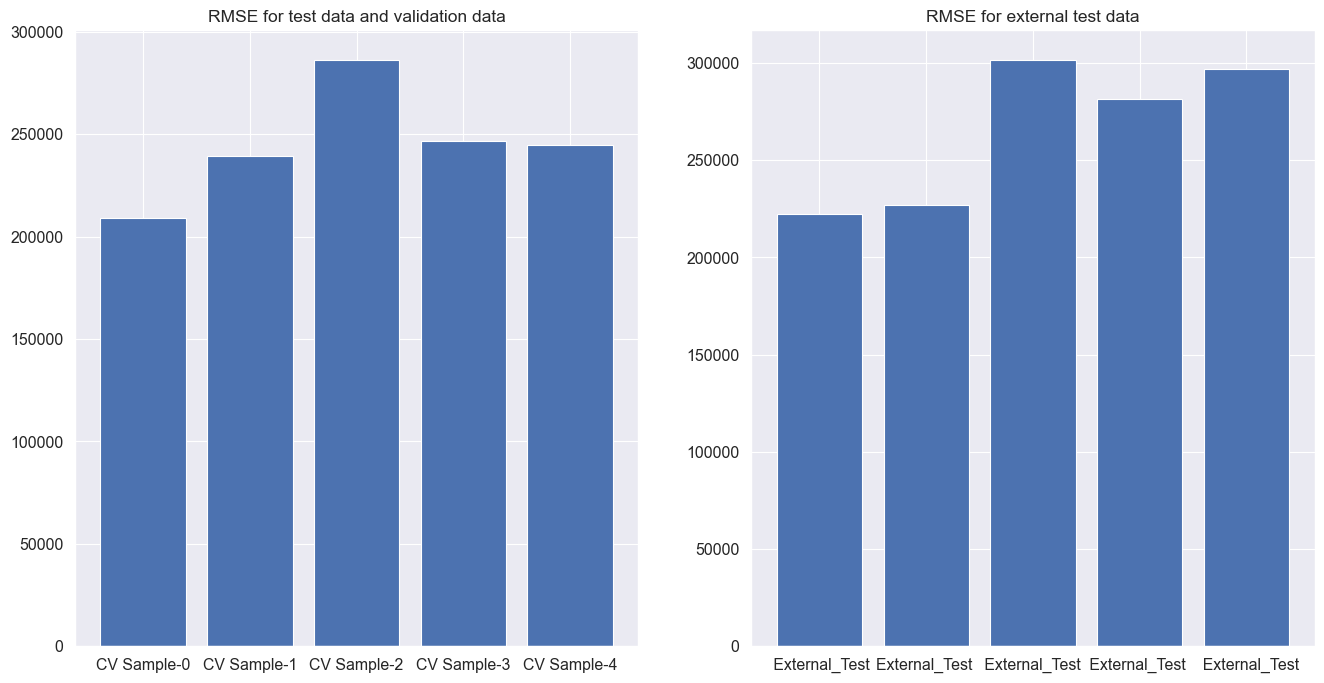

In [12]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_PSO_CarSales_lightgbm,
                                                  cost_funct=cost_funct)
print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Particle Swarm Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


Average Test and Validation Cost: 337565.54 Average External Test Cost: 286731.93
Car Sales dataset - Ant Colony Optimization


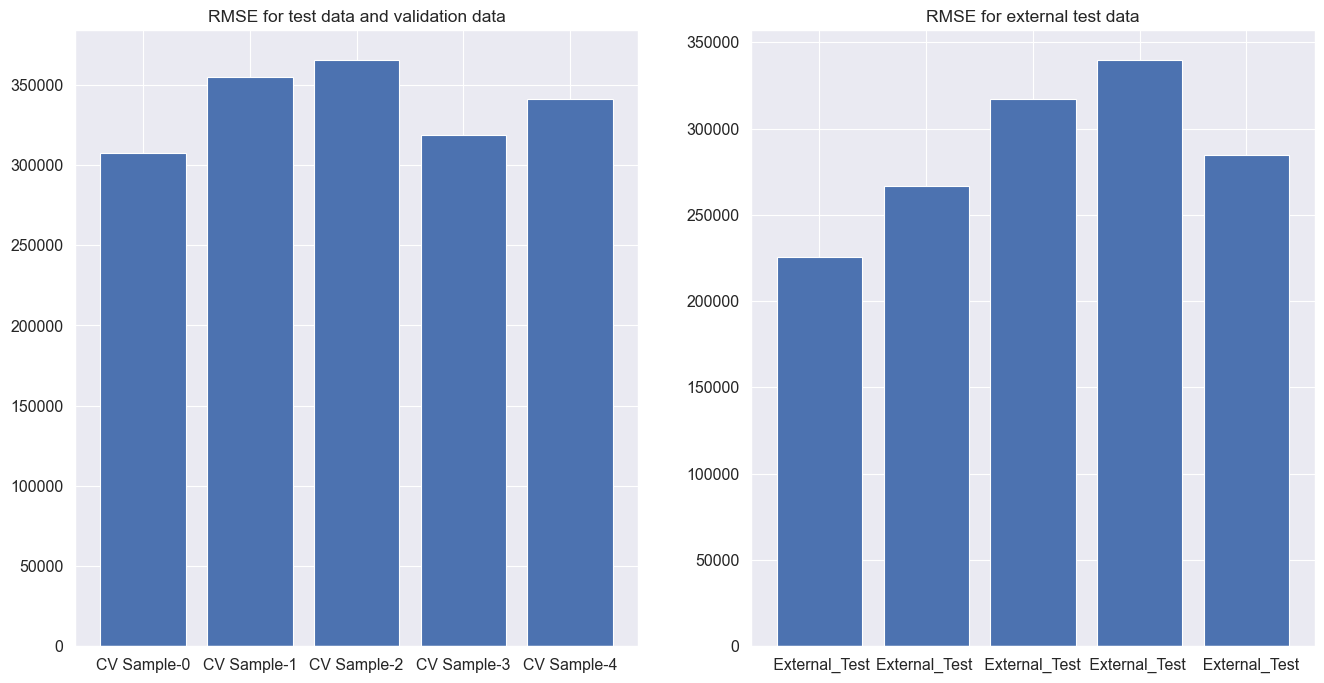

In [13]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1)#,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_ACO_CarSales_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Ant Colony Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


Average Test and Validation Cost: 197495.33 Average External Test Cost: 224033.84
Car Sales dataset - Simulated Annealing


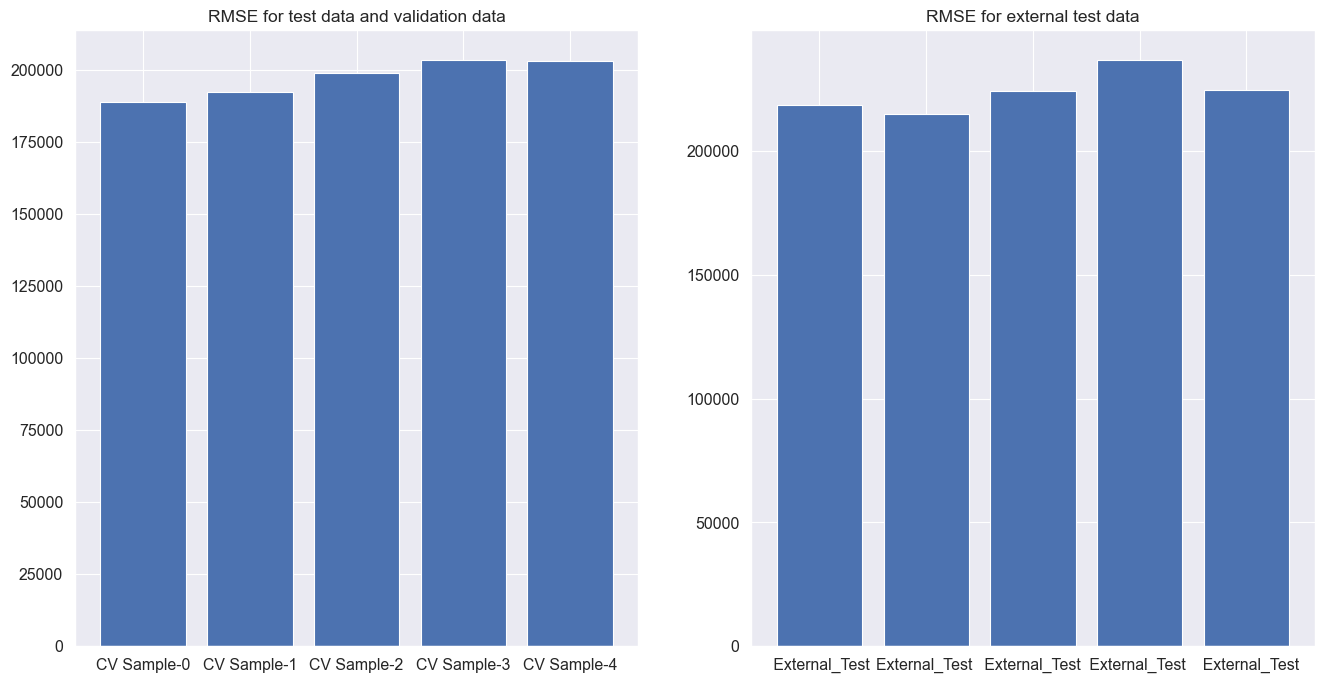

In [14]:
#model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1)
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_SA_CarSales_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Simulated Annealing'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


Average Test and Validation Cost: 241793.69 Average External Test Cost: 255420.76
Car Sales dataset - Genetic Algorithm


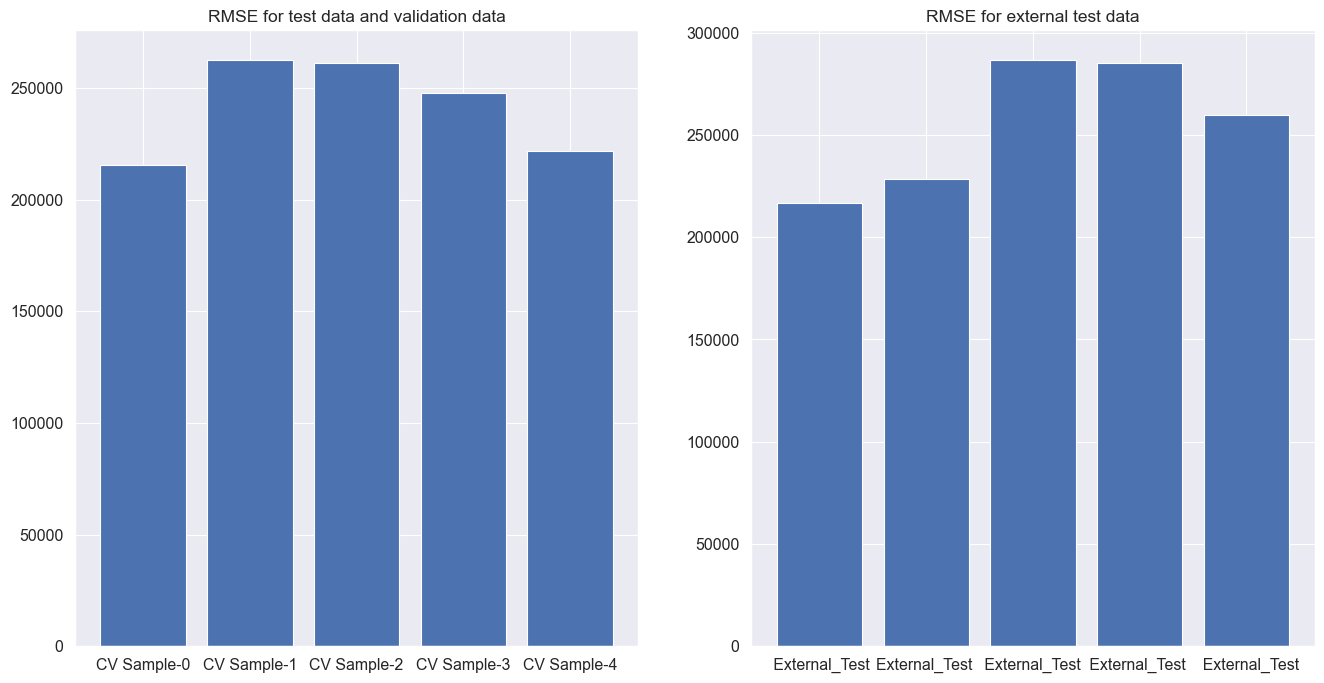

In [15]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_CarSales_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


## Xgboost

In [16]:
# model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=100)
model_use = XGBRegressor(n_estimators=200,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
# model_use = RandomForestRegressor(random_state=1,n_jobs=-1,n_estimators=200)

fsObj = FeatureSelection(columns_list = tree_features_all,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'decrease',
                         average = None)

In [17]:
#### Particle Swarm Optimization
best_columns_PSO_CarSales_xgboost = fsObj.ParticleSwarmOptimization(iterations = 25,                                                                   
                                                                       swarmSize = 75,
                                                                       run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_PSO_CarSales_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_PSO_CarSales_xgboost, output_file)

Best combined performance on test and validation data for iteration 0: 328716.46969789406
Best combined performance on test and validation data for iteration 1: 328716.46969789406
Best combined performance on test and validation data for iteration 2: 268755.2578381311
Best combined performance on test and validation data for iteration 3: 249542.6039926599
Best combined performance on test and validation data for iteration 4: 249542.6039926599
Best combined performance on test and validation data for iteration 5: 249542.6039926599
Best combined performance on test and validation data for iteration 6: 249542.6039926599
Best combined performance on test and validation data for iteration 7: 246829.7542436496
Best combined performance on test and validation data for iteration 8: 246829.7542436496
Best combined performance on test and validation data for iteration 9: 246829.7542436496
Best combined performance on test and validation data for iteration 10: 246829.7542436496
Best combined perf

In [18]:
#### Ant Colony Optimization
best_columns_ACO_CarSales_xgboost = fsObj.AntColonyOptimization(iterations = 25,
                                                                N_ants = 75,
                                                                run_time=1200,
                                                                evaporation_rate=0.8,
                                                                Q=0.2)

with open(r"D:\\Results\\ResultPickle\\best_columns_ACO_CarSales_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_ACO_CarSales_xgboost, output_file)

Best combined performance on test and validation data for iteration 0: 345097.23943700775
Best combined performance on test and validation data for iteration 1: 310948.2097220628
Best combined performance on test and validation data for iteration 2: 310948.2097220628
Best combined performance on test and validation data for iteration 3: 290908.9323993525
Best combined performance on test and validation data for iteration 4: 284479.8253730412
Best combined performance on test and validation data for iteration 5: 283859.13700238464
Best combined performance on test and validation data for iteration 6: 277432.302747176
Best combined performance on test and validation data for iteration 7: 277383.51604856923
Best combined performance on test and validation data for iteration 8: 277258.05866576417
Best combined performance on test and validation data for iteration 9: 277252.23643379303
Best combined performance on test and validation data for iteration 10: 277252.23643379303
Best combined p

In [19]:
#### Simulated Annealing
best_columns_SA_CarSales_xgboost = fsObj.SimulatedAnnealing(temperature = 1500,
                                                               iterations = 35,
                                                               n_perturb = 75,
                                                               run_time=1200,
                                                               n_features_percent_perturb=1,
                                                               alpha=0.9)

with open(r"D:\\Results\\ResultPickle\\best_columns_SA_CarSales_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_SA_CarSales_xgboost, output_file)

Best combined performance on test and validation data for iteration 0: 565223.9153583549
Best combined performance on test and validation data for iteration 1: 548025.5118010839
Best combined performance on test and validation data for iteration 2: 546971.7923568266
Best combined performance on test and validation data for iteration 3: 528242.1544763108
Best combined performance on test and validation data for iteration 4: 524567.5306017327
Best combined performance on test and validation data for iteration 5: 516491.9645220443
Best combined performance on test and validation data for iteration 6: 432446.86285454594
Best combined performance on test and validation data for iteration 7: 431439.2941931118
Best combined performance on test and validation data for iteration 8: 389769.7676189853
Best combined performance on test and validation data for iteration 9: 387474.4993432543
Best combined performance on test and validation data for iteration 10: 360479.3026128236
Best combined perfo

In [20]:
#### Genetic Algorithm
best_columns_GA_CarSales_xgboost = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_CarSales_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_CarSales_xgboost, output_file)

Best combined performance on test and validation data for generation 0 : 354151.8789583867
Best combined performance on test and validation data for generation 1 : 327864.3020072468
Best combined performance on test and validation data for generation 2 : 318473.70034851
Best combined performance on test and validation data for generation 3 : 311875.7690497091
Best combined performance on test and validation data for generation 4 : 303040.3207784962
Best combined performance on test and validation data for generation 5 : 294456.84086939367
Best combined performance on test and validation data for generation 6 : 303583.70316172775
Best combined performance on test and validation data for generation 7 : 297329.8149940897
Best combined performance on test and validation data for generation 8 : 293188.0367399411
Best combined performance on test and validation data for generation 9 : 286974.6777613368
Best combined performance on test and validation data for generation 10 : 281564.315111359

Average Test and Validation Cost: 228862.32 Average External Test Cost: 248202.45
Car Sales dataset - Particle Swarm Optimization


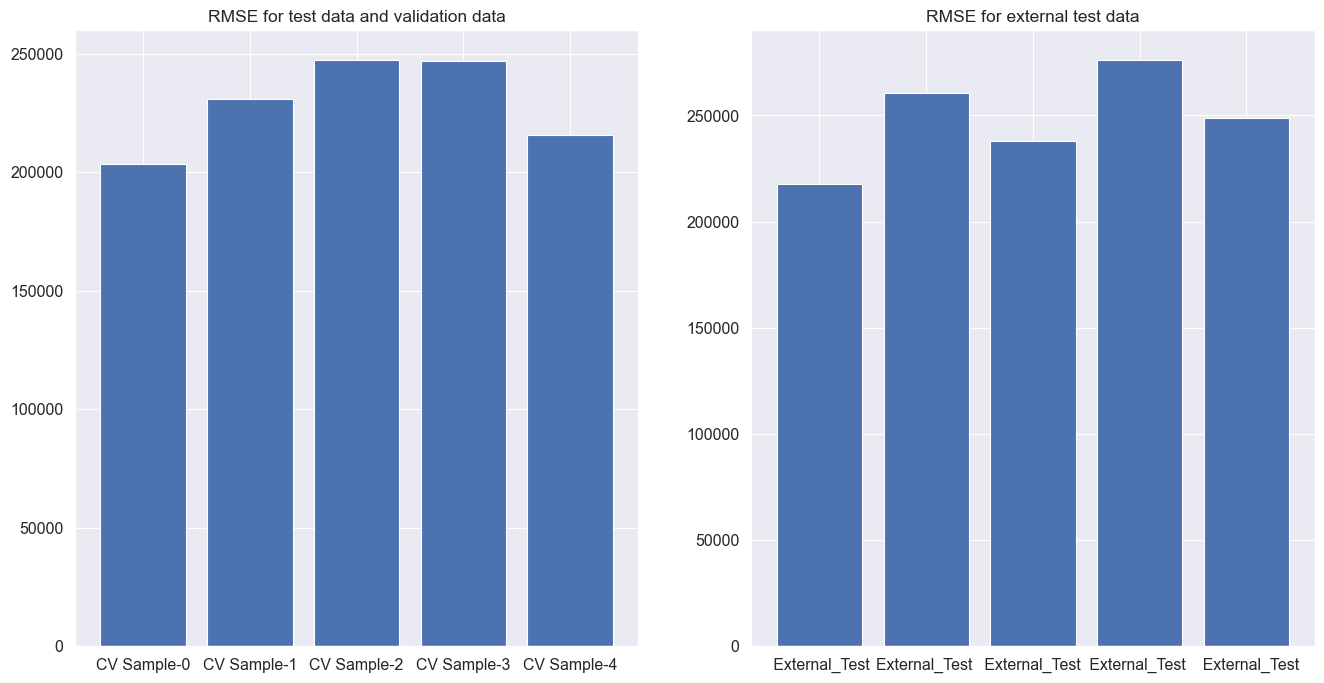

In [21]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_PSO_CarSales_xgboost,
                                                  cost_funct=cost_funct)
print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Particle Swarm Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

Average Test and Validation Cost: 277252.24 Average External Test Cost: 284764.45
Car Sales dataset - Ant Colony Optimization


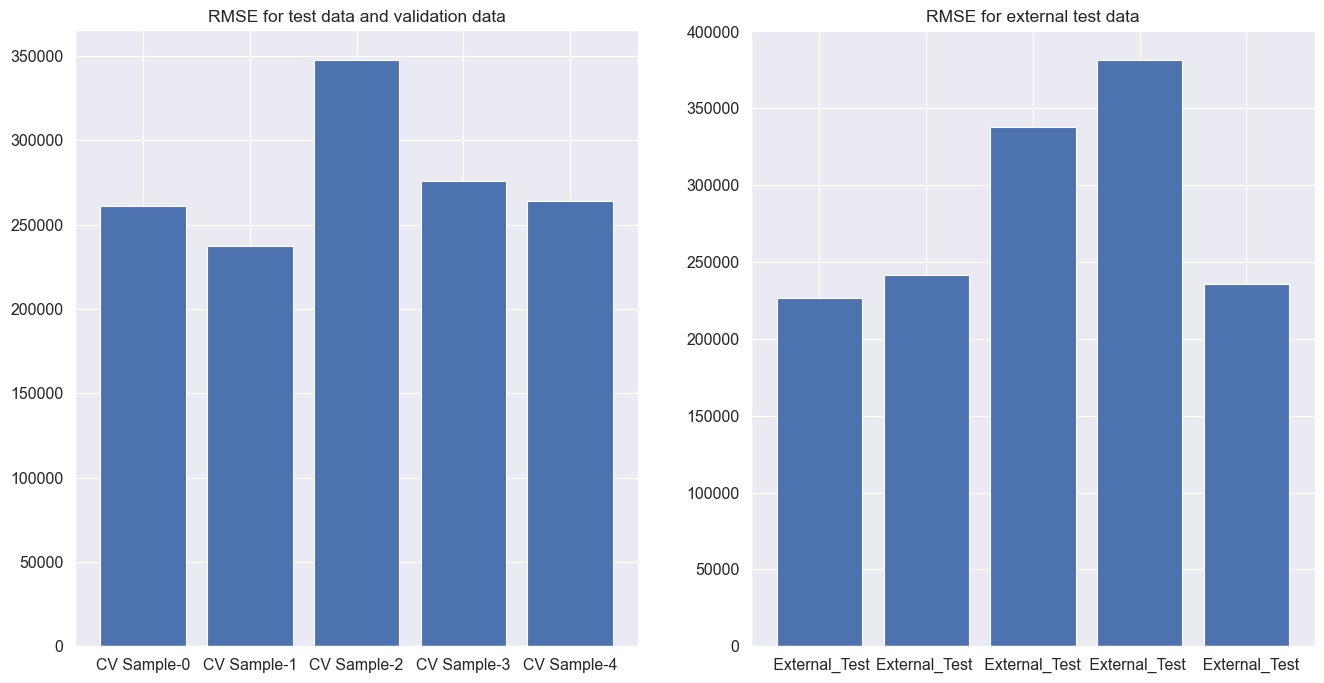

In [22]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1)#,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_ACO_CarSales_xgboost,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Ant Colony Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

Average Test and Validation Cost: 226203.63 Average External Test Cost: 238978.07
Car Sales dataset - Simulated Annealing


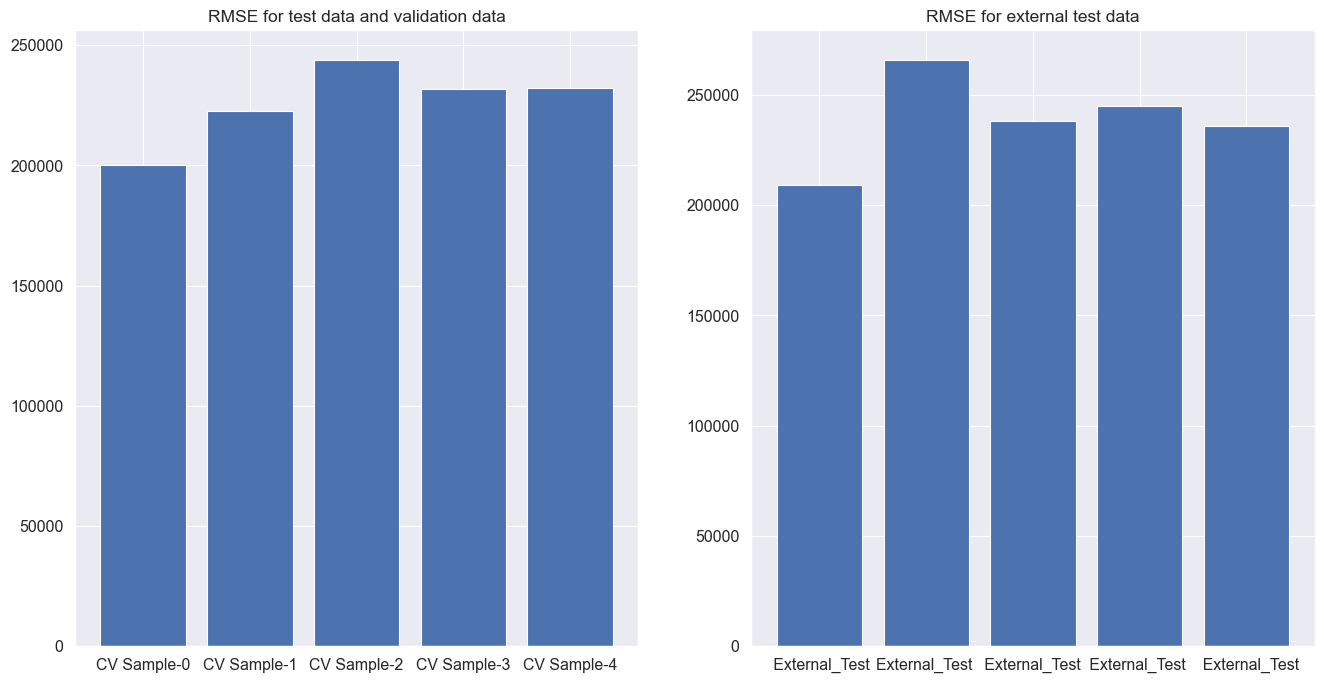

In [23]:
#model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1)
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_SA_CarSales_xgboost,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Simulated Annealing'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

Average Test and Validation Cost: 272620.27 Average External Test Cost: 293171.44
Car Sales dataset - Genetic Algorithm


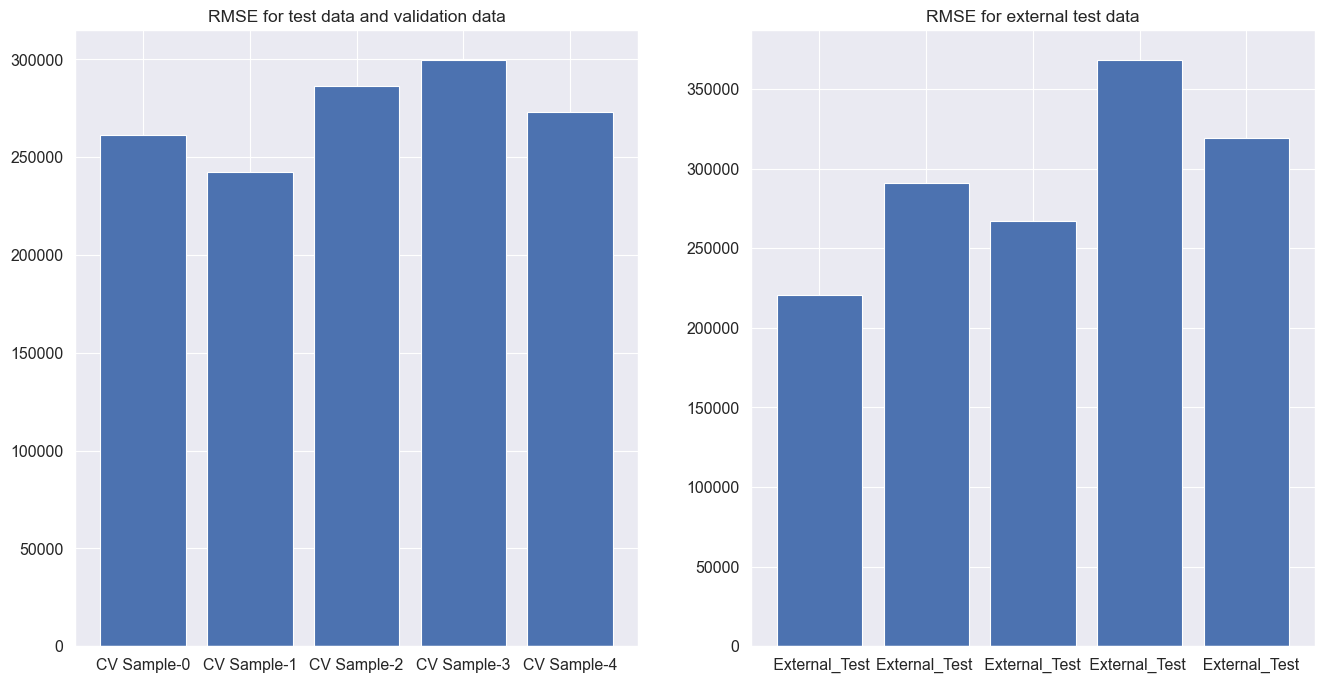

In [24]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_CarSales_xgboost,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

## Linear Regression

In [25]:
patch_sklearn()
model_use = LinearRegression(n_jobs=-1)

fsObj = FeatureSelection(columns_list = common_list,
                         data_dict = data_dict_for_linear,
                         x_validation_dataframe = x_validation_linear,
                         y_validation_dataframe = y_validation_linear,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'decrease',
                         average = None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [26]:
#### Particle Swarm Optimization
best_columns_PSO_CarSales_linear = fsObj.ParticleSwarmOptimization(iterations = 25,                                                                   
                                                                       swarmSize = 75,
                                                                       run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_PSO_CarSales_linear.pickle", "wb") as output_file:
    pickle.dump(best_columns_PSO_CarSales_linear, output_file)

Best combined performance on test and validation data for iteration 0: 366864.0503929039
Best combined performance on test and validation data for iteration 1: 366864.0503929039
Best combined performance on test and validation data for iteration 2: 318502.7021705456
Best combined performance on test and validation data for iteration 3: 298988.42439569737
Best combined performance on test and validation data for iteration 4: 298988.42439569737
Best combined performance on test and validation data for iteration 5: 298988.42439569737
Best combined performance on test and validation data for iteration 6: 298988.42439569737
Best combined performance on test and validation data for iteration 7: 298510.6363570454
Best combined performance on test and validation data for iteration 8: 290345.06477639586
Best combined performance on test and validation data for iteration 9: 289896.46729836595
Best combined performance on test and validation data for iteration 10: 289896.46729836595
Best combined

In [27]:
#### Ant Colony Optimization
best_columns_ACO_CarSales_linear = fsObj.AntColonyOptimization(iterations = 25,
                                                                N_ants = 75,
                                                                run_time=1200,
                                                                evaporation_rate=0.8,
                                                                Q=0.2)

with open(r"D:\\Results\\ResultPickle\\best_columns_ACO_CarSales_linear.pickle", "wb") as output_file:
    pickle.dump(best_columns_ACO_CarSales_linear, output_file)

Best combined performance on test and validation data for iteration 0: 350668.53028691205
Best combined performance on test and validation data for iteration 1: 331926.4781524804
Best combined performance on test and validation data for iteration 2: 327936.1072620725
Best combined performance on test and validation data for iteration 3: 318773.7162908277
Best combined performance on test and validation data for iteration 4: 312897.27390581043
Best combined performance on test and validation data for iteration 5: 308612.8550256388
Best combined performance on test and validation data for iteration 6: 306340.4901064121
Best combined performance on test and validation data for iteration 7: 305401.5406250792
Best combined performance on test and validation data for iteration 8: 305354.37315015116
Best combined performance on test and validation data for iteration 9: 305354.37315015116
Best combined performance on test and validation data for iteration 10: 305354.3731336555
Best combined pe

In [28]:
#### Simulated Annealing
best_columns_SA_CarSales_linear = fsObj.SimulatedAnnealing(temperature = 1500,
                                                               iterations = 35,
                                                               n_perturb = 75,
                                                               run_time=1200,
                                                               n_features_percent_perturb=1,
                                                               alpha=0.9)

with open(r"D:\\Results\\ResultPickle\\best_columns_SA_CarSales_linear.pickle", "wb") as output_file:
    pickle.dump(best_columns_SA_CarSales_linear, output_file)

Best combined performance on test and validation data for iteration 0: 479122.1413082674
Best combined performance on test and validation data for iteration 1: 399284.65752500325
Best combined performance on test and validation data for iteration 2: 363518.64305110613
Best combined performance on test and validation data for iteration 3: 363518.64305110613
Best combined performance on test and validation data for iteration 4: 358474.6088757704
Best combined performance on test and validation data for iteration 5: 354827.8397811196
Best combined performance on test and validation data for iteration 6: 351159.96093867783
Best combined performance on test and validation data for iteration 7: 351159.96093867783
Best combined performance on test and validation data for iteration 8: 325538.74526775535
Best combined performance on test and validation data for iteration 9: 314117.3159351819
Best combined performance on test and validation data for iteration 10: 314117.3159351819
Best combined 

In [29]:
#### Genetic Algorithm
best_columns_GA_CarSales_linear = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_CarSales_linear.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_CarSales_linear, output_file)

Best combined performance on test and validation data for generation 0 : 331006.00795261253
Best combined performance on test and validation data for generation 1 : 334831.74813508894
Best combined performance on test and validation data for generation 2 : 344365.48551108077
Best combined performance on test and validation data for generation 3 : 304845.6322746243
Best combined performance on test and validation data for generation 4 : 314492.057602908
Best combined performance on test and validation data for generation 5 : 315161.1703668214
Best combined performance on test and validation data for generation 6 : 302886.6191914109
Best combined performance on test and validation data for generation 7 : 309262.50079108553
Best combined performance on test and validation data for generation 8 : 308520.00615820504
Best combined performance on test and validation data for generation 9 : 305178.8169680238
Best combined performance on test and validation data for generation 10 : 299043.37326

Average Test and Validation Cost: 289058.09 Average External Test Cost: 2062332528.42
Car Sales dataset - Particle Swarm Optimization


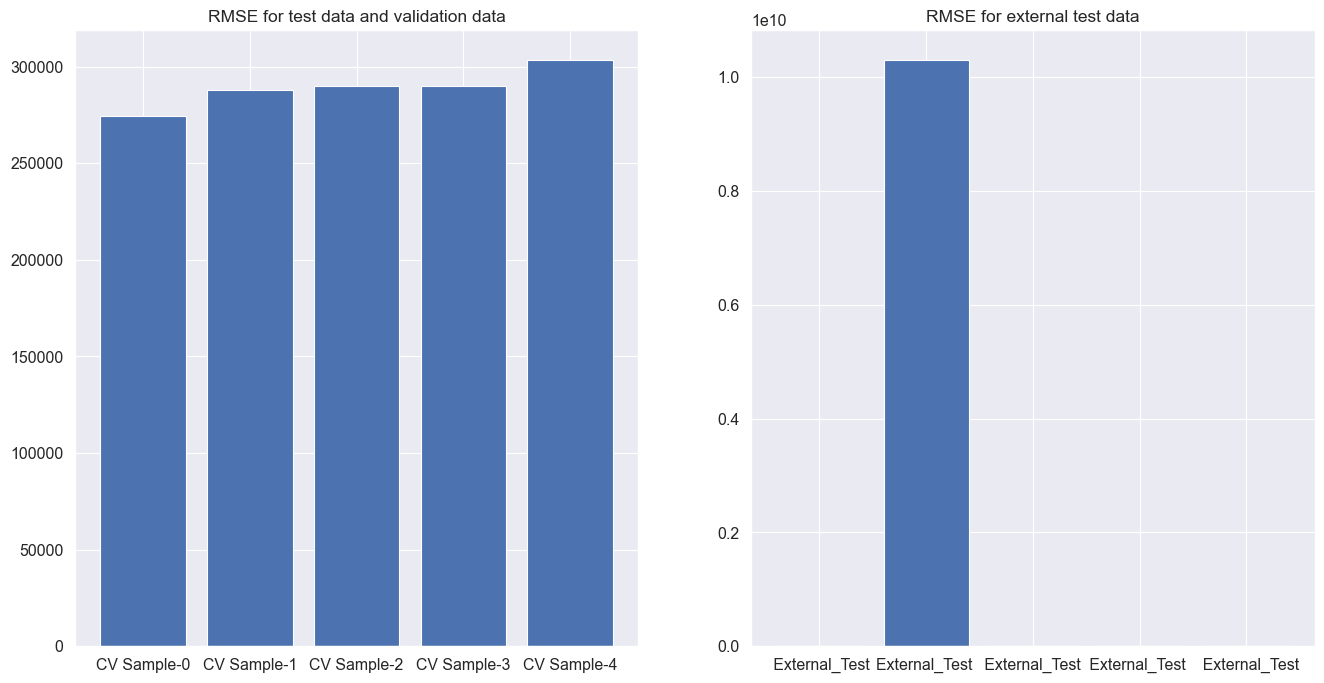

In [30]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_PSO_CarSales_linear,
                                                  cost_funct=cost_funct)
print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Particle Swarm Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

Average Test and Validation Cost: 305308.75 Average External Test Cost: 320874.55
Car Sales dataset - Ant Colony Optimization


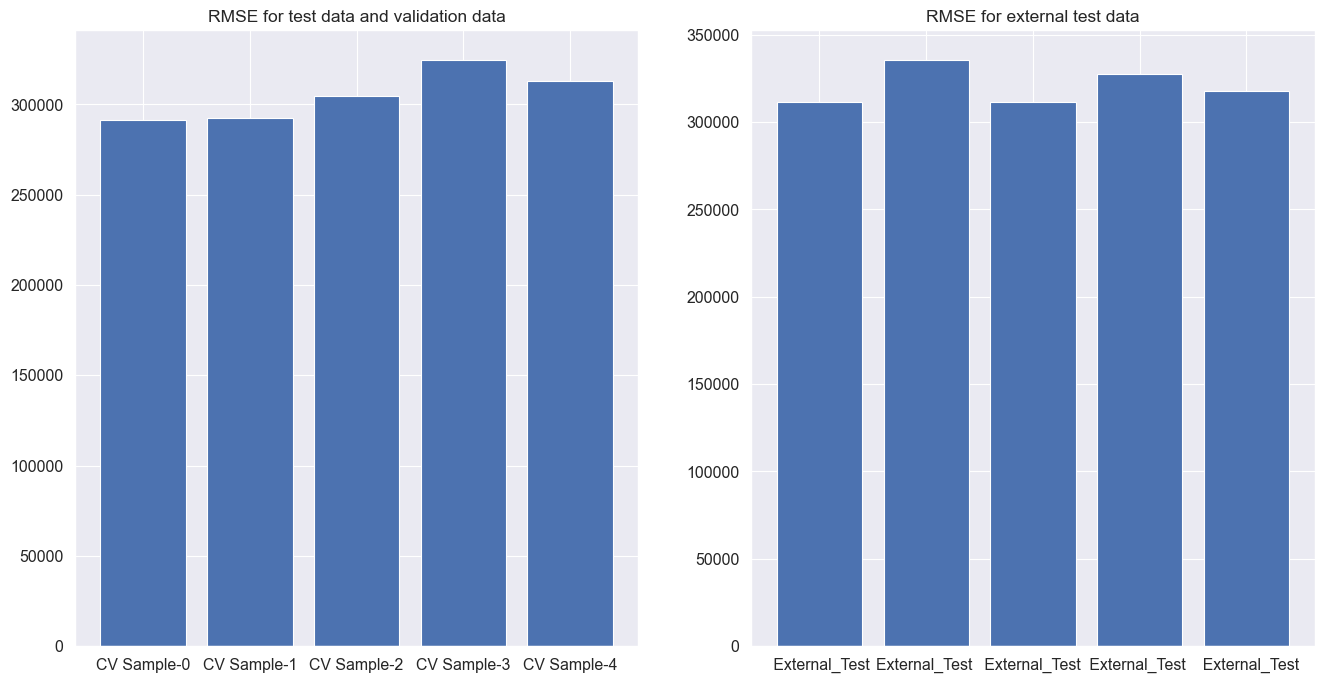

In [31]:
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_ACO_CarSales_linear,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Ant Colony Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

Average Test and Validation Cost: 268426.06 Average External Test Cost: 316116.28
Car Sales dataset - Simulated Annealing


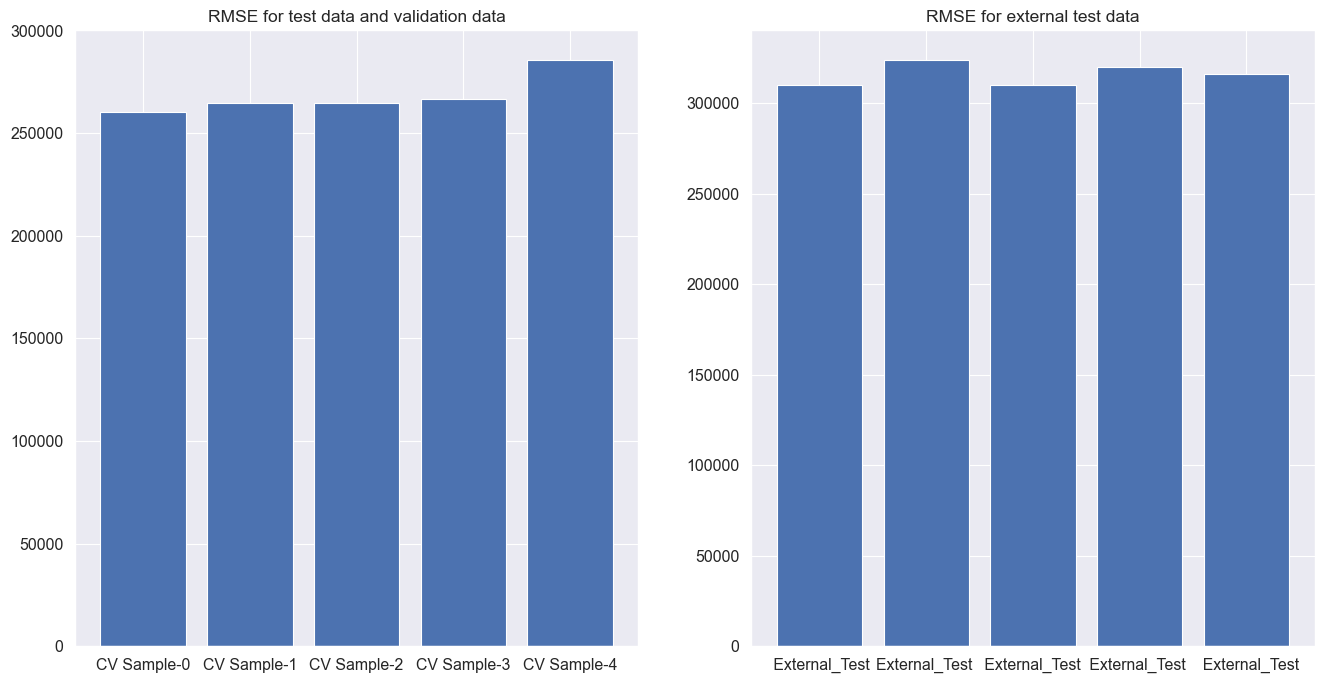

In [32]:
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_SA_CarSales_linear,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Simulated Annealing'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

Average Test and Validation Cost: 286866.73 Average External Test Cost: 325208.47
Car Sales dataset - Genetic Algorithm


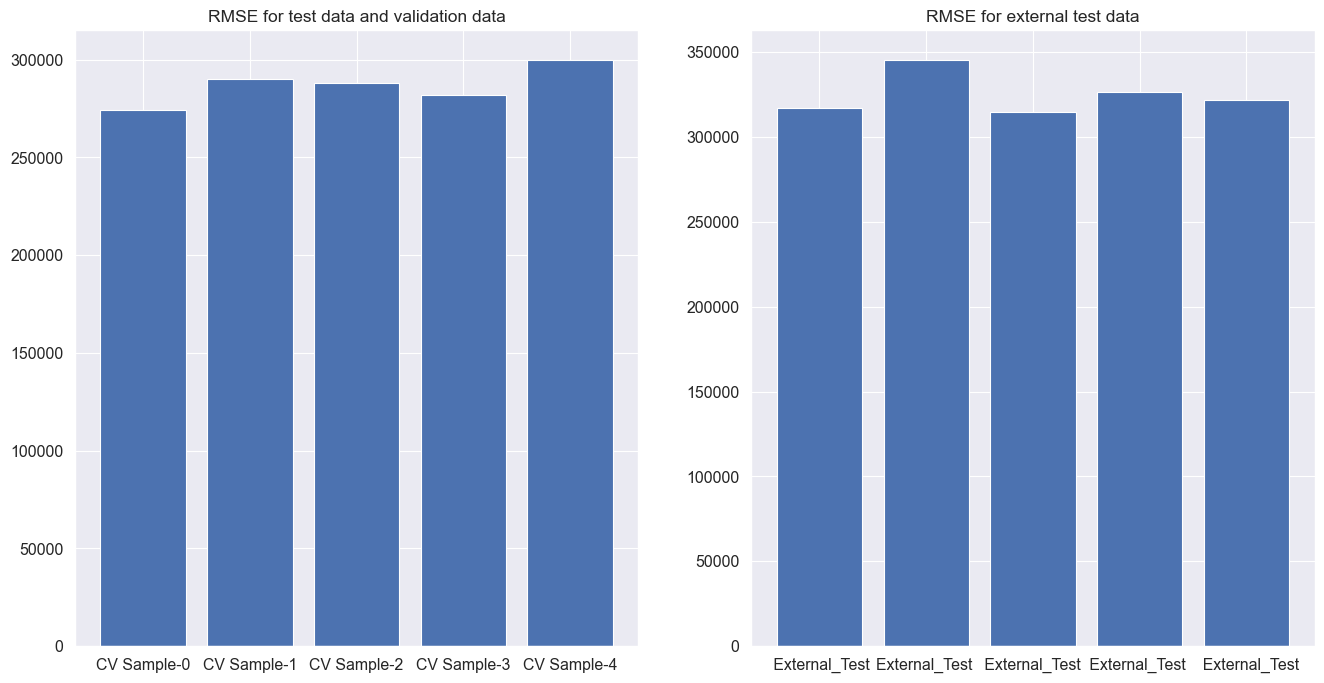

In [33]:
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_CarSales_linear,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Car Sales dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

In [34]:
unpatch_sklearn()